# Machine Learning for data analysis

## Topic : K-means clustering
Cluster analysis is an *unsupervised machine* learning method that partitions the observations in a data set into a smaller set of clusters where each observation belongs to only one cluster. The goal of cluster analysis is to group, or cluster, observations into subsets based on their similarity of responses on multiple variables. Clustering variables should be primarily quantitative variables, but binary variables may also be included.

### Run a K-means clustering 
Your assignment is to run a k-means cluster analysis to identify subgroups of observations in your data set that have similar patterns of response on a set of clustering variables.

### What to submit:
Following completion of the steps described above, create a blog entry where you submit syntax used to run a k-means cluster analysis (copied and pasted from your program) along with corresponding output and a brief written summary. Please note that your reviewers should NOT be required to download any files in order to complete the review.

This assignment does NOT require you to run your cluster analysis again on a test data set. You are welcome to do so, but you are only required to run your cluster analysis once on your training data set. If your data set has a relatively small number of observations, you do not need to split into training and test data sets. You can provide your rationale for not splitting your data set in your written summary.

### Data Set : Cars Data 

Cars Data has Information about 3 brands/make of cars. Namely US, Japan, Europe. Target of the data set to find the brand of a car using the parameters such as:

- mpg
- clylinders 
- cubicinches 
- hp(horse power)
- weightslbs
- time-to-60 
- year

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans


import warnings # ignore warning message
warnings.filterwarnings('ignore')

### 1. Data Management 

In [2]:
#Load the dataset
data = pd.read_csv("cars_data.csv")

#simple data cleaning 
data_clean = data.convert_objects(convert_numeric=True)
data_clean.dtypes

mpg             float64
 cylinders        int64
 cubicinches    float64
 hp               int64
 weightlbs      float64
 time-to-60       int64
 year             int64
 brand           object
dtype: object

In [3]:
# subset clustering variables
cluster=data_clean[['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',' year']]

In [4]:
#Scale the data using min max normalization method
col=['mpg', ' cylinders', ' cubicinches', ' hp', ' weightlbs', ' time-to-60',' year']

mean_cluster=cluster[col].mean()
std_cluster=cluster[col].std() 
scaled_cluster=(cluster[col]-mean_cluster)/std_cluster
scaled_cluster=scaled_cluster.astype('float64')
scaled_cluster = scaled_cluster.dropna()

Data were randomly split into a training set that included 70% of the observations and a test set that included 30% of the observations. 

In [5]:
# split data into train and test sets
clus_train, clus_test = train_test_split(scaled_cluster, test_size=.3, random_state=123)

### 2. Modeling

In [6]:
# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
#try k=1 to k=10
clusters=range(1,10)
#avergae distance measure 
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

Text(0.5,1,'Selecting k with the Elbow Method')

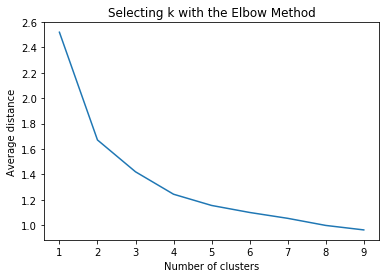

In [7]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

In [8]:
# Based on the elbow method above, we try to interpret a "4-cluster" solution
model4=KMeans(n_clusters=4)
model4.fit(clus_train)
clusassign=model4.predict(clus_train)

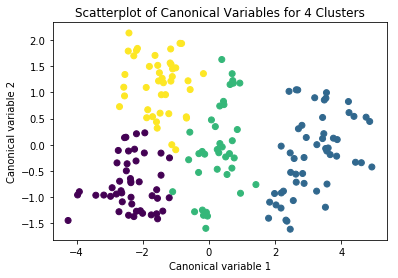

In [9]:
#visualizing clustering using data reduction technique (PCA)
from sklearn.decomposition import PCA
canonical_n=2
pca_2 = PCA(canonical_n)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model4.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 Clusters')
plt.show()

In [10]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model4.labels_)
# combine index variable list with cluster assignment list into a dictionary
#combine lists using "zip"
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
#rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

1    52
0    47
3    42
2    38
Name: cluster, dtype: int64

In [11]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
              index       mpg   cylinders   cubicinches        hp   weightlbs  \
cluster                                                                         
0        139.404255  1.208278   -0.905067     -0.831952 -0.801644   -0.824871   
1        112.750000 -1.077196    1.390382      1.426615  1.402315    1.304675   
2        148.789474 -0.441659    0.206155      0.104552 -0.083617    0.263649   
3        126.071429  0.283080   -0.931079     -0.874423 -0.641462   -0.861648   

          time-to-60      year  
cluster                         
0           0.571999  1.166647  
1          -1.053768 -0.553161  
2           0.200536  0.035035  
3           0.376196 -0.722833  


In [13]:
data_clean["carscore"] = data_clean[" brand"].map({" US.": 1, " Europe.": 2," Japan.": 3})

# validate clusters in training data by examining cluster differences in brand using ANOVA
# first have to merge brand with clustering variables and cluster assignment data 
brand_data=data_clean['carscore']
# split brand data into train and test sets
brand_train, brand_test = train_test_split(brand_data, test_size=.3, random_state=123)
brand_train1=pd.DataFrame(brand_train)
brand_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(brand_train1, merged_train, on='index')
sub1 = merged_train_all[['carscore', 'cluster']].dropna()

In [14]:
#Analysis of variance to test whether there are significant differences btw cluster on quantitative carscore variable 
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

#using ols regression:
carscoremod = smf.ols(formula='carscore ~ C(cluster)', data=sub1).fit()
print (carscoremod.summary())

                            OLS Regression Results                            
Dep. Variable:               carscore   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     29.34
Date:                Fri, 15 May 2020   Prob (F-statistic):           2.09e-14
Time:                        17:17:37   Log-Likelihood:                -116.15
No. Observations:                 128   AIC:                             240.3
Df Residuals:                     124   BIC:                             251.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1724      0.113     

In [15]:
print ('means for carscore by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

means for carscore by cluster
         carscore
cluster          
0        2.172414
1        1.000000
2        1.333333
3        2.062500


In [16]:
print ('standard deviations for carscore by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for carscore by cluster
         carscore
cluster          
0        0.848064
1        0.000000
2        0.679366
3        0.669015


In [17]:
#request a tukey test to evaluate post hot comparisons between the clusters using the multi comparison function
mc1 = multi.MultiComparison(sub1['carscore'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.1724  0.001 -1.5593 -0.7855   True
     0      2  -0.8391  0.001 -1.2634 -0.4148   True
     0      3  -0.1099 0.8903 -0.5167  0.2968  False
     1      2   0.3333 0.1296 -0.0618  0.7285  False
     1      3   1.0625  0.001  0.6862  1.4388   True
     2      3   0.7292  0.001  0.3146  1.1437   True
----------------------------------------------------


### Conclusion

#### Background:
A k-means cluster analysis was conducted to identify types of car based on a few variables that associate to ones' car including mpg,clylinders, cubicinches, horse power, weightslbs, time-to-60 as well as the year where the car is first introduced.All clustering variables were scaled using standardization method to avoid of problem of large data affecting the interpretation of result.

#### Modeling:
A series of k-means cluster analyses were conducted on the training data specifying k=1 to 9 clusters, using Euclidean distance. The avergae distance was plotted for each of the nine cluster solutions in an elbow curve to provide guidance for choosing the number of clusters to interpret.
Data were randomly split into a training set that included 70% of the observations and a test set that included 30% of the observations. A series of k-means cluster analyses were conducted on the training data specifying k=1 to 9 clusters, using Euclidean distance. he avergae distance was plotted for each of the nine cluster solutions in an elbow curve to provide guidance for choosing the number of clusters to interpret.

#### Evaluation:
Based on the means oe the clustering variables, cluster (labeled "1") emegered to be the best car type with notably the highest mpg, cylinders, cubicinches, horse power as well as weights. In contrast, cluster (labeled "2") appeared to be the least ideal car type with the lowest cubicinches, horse power as well as weights. In order to externally validate the clusters, an Analysis of Variance (ANOVA) was conducting to test for significant differences between the clusters on car score.A tukey test was used for post hoc comparisons between the clusters. The tukey post hoc comparisons showed significant differences between clusters on car score. 